In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn import metrics,preprocessing
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,RandomForestRegressor
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn import datasets
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


In [2]:
df =  pd.read_pickle('../data.2021-02-27.scenarioJunction.pkl.gz').drop(['meta_scenario', 'meta_p_red', 'meta_p_blue', 'meta_seed'], axis=1, errors="ignore")

In [3]:
df.dropna(axis=1, how='all',inplace=True)

In [24]:
def createDf(df):    
    df_red = df[df['action_team'] == 'red'].copy().drop('action_team', axis=1)
    df_blue = df[df['action_team'] == 'blue'].copy().drop('action_team', axis=1)
    df_red['label'] = df_red['winner'].apply(lambda x: 1 if x == 'red' else -1)
    df_blue['label'] = df_blue['winner'].apply(lambda x: 1 if x == 'blue' else -1)
    df_new=pd.concat([df_red,df_blue])
    df_neg=df_new[df_new['label']==-1]
    df_pos=df_new[df_new['label']==1]


    return df_red,df_blue,df_new,df_neg,df_pos

In [25]:
df_red,df_blue,df_new,df_neg,df_pos=createDf(df)

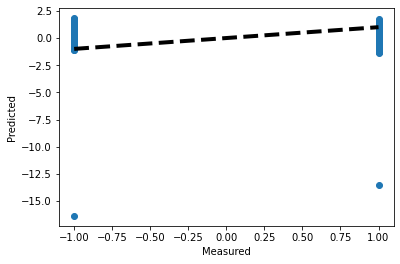

In [21]:
def CrossValidatedPredictions(df):

    lr = linear_model.LinearRegression()
    X = df.drop(['winner', 'label'], axis=1)
    y = df['label']

    # cross_val_predict returns an array of the same size as `y` where each entry
    # is a prediction obtained by cross validation:
    predicted = cross_val_predict(lr, X, y, cv=10)

    fig, ax = plt.subplots()
    ax.scatter(y, predicted)
    #ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.show()


In [27]:
def crossValidatedPredictionsRegressor(df):

    regr = RandomForestRegressor()
    X = df.drop(['winner', 'label'], axis=1)
    y = df['label']

    # cross_val_predict returns an array of the same size as `y` where each entry
    # is a prediction obtained by cross validation:
    predicted = cross_val_predict(regr, X, y, cv=10)

    fig, ax = plt.subplots()
    ax.scatter(y, predicted)
    #ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.show()


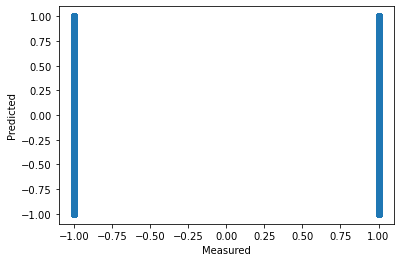

In [28]:
crossValidatedPredictionsRegressor(df_new)

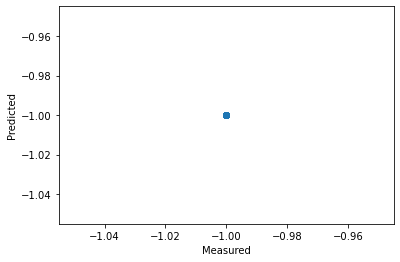

In [29]:
crossValidatedPredictionsRegressor(df_neg)

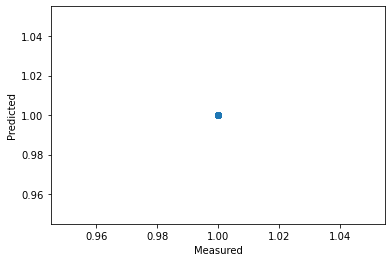

In [32]:
crossValidatedPredictionsRegressor(df_pos)

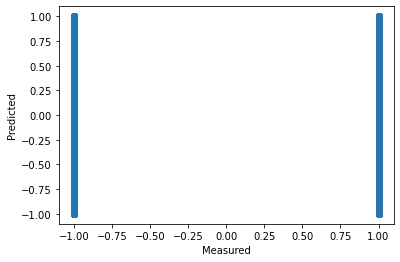

In [33]:
crossValidatedPredictionsRegressor(df_red)

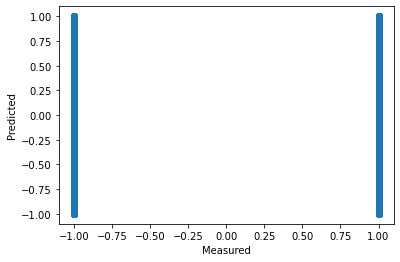

In [34]:
crossValidatedPredictionsRegressor(df_blue)

In [30]:
def random_regressor(df):
    X = df.drop(['winner', 'label'], axis=1)
    y = df['label']
    train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size = 0.25, random_state = 42)
    regr = RandomForestRegressor()
    regr.fit(X, y)
    predictions = regr.predict(test_features)

    # Calculate the absolute errors
    errors = abs(predictions - test_labels)
    # Print out the mean absolute error (mae)
    print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / test_labels)
    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    print('Mean Absolute Error:', metrics.mean_absolute_error(test_labels, predictions))
    print('Mean Squared Error:', metrics.mean_squared_error(test_labels, predictions))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_labels, predictions)))


In [31]:
random_regressor(df_new)

Mean Absolute Error: 0.23 degrees.
99.98331015299027
Mean Absolute Error: 0.22807371349095967
Mean Squared Error: 0.08355048678720445
Root Mean Squared Error: 0.2890510107008873


In [17]:
random_regressor(df_red)

Mean Absolute Error: 0.11 degrees.
Mean Absolute Error: 0.10910096818810514
Mean Squared Error: 0.02896403872752421
Root Mean Squared Error: 0.17018824497456989


In [18]:
random_regressor(df_blue)

Mean Absolute Error: 0.12 degrees.
Mean Absolute Error: 0.12409646976581616
Mean Squared Error: 0.03568682278923453
Root Mean Squared Error: 0.1889095624610743


In [19]:
def random_forest(df):
    f_select=[]
   
    X = df.drop(['winner', 'label'], axis=1)
    y = df['label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    clf = RandomForestClassifier(n_estimators=100)

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    proba = clf.predict_proba(X_test)
    proba = np.around(proba, decimals=2)
    print(y_train)


    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

    # feature importanti per determinarlo
    feature_imp = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
    print('Feature importance:\n', feature_imp)
    f_selection=feature_imp[(feature_imp>0)]
    print('Feature selection:\n',f_selection)
            
        
    # Creating a bar plot
    sns.barplot(x=f_selection, y=f_selection.index)
    # Add labels to your graph
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Visualizing Important Features")
    plt.legend()
    plt.show()
    #return X_test, y_test, y_pred, proba


4     1
37    1
13   -1
14    1
15   -1
     ..
8    -1
14   -1
22   -1
14   -1
1     1
Name: label, Length: 16105, dtype: int64
[[2505  923]
 [ 768 2707]]
              precision    recall  f1-score   support

          -1       0.77      0.73      0.75      3428
           1       0.75      0.78      0.76      3475

    accuracy                           0.76      6903
   macro avg       0.76      0.75      0.75      6903
weighted avg       0.76      0.76      0.75      6903

Accuracy: 0.7550340431696364
Feature importance:
 blue_goal_GoalDefendPoint_score    0.031156
action_destination_x               0.018145
action_destination_z               0.017440
red_goal_GoalReachPoint_score      0.017241
red_LOS_2_2                        0.015573
                                     ...   
blue_figure_0_weapon_GR            0.000000
blue_figure_0_weapon_MT            0.000000
blue_figure_0_weapon_AT            0.000000
blue_figure_0_weapon_MG            0.000000
blue_figure_1_hp_max       

No handles with labels found to put in legend.


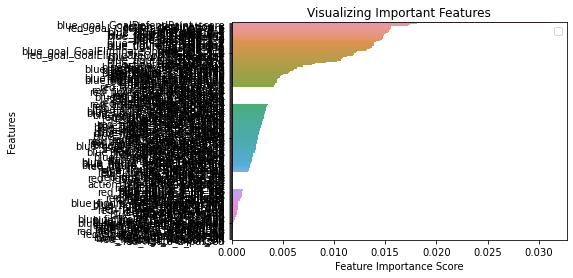

In [20]:
random_forest(df_new)